In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [ ]:
data = pd.read_csv('data.csv')
data


In [2]:
from sklearn.preprocessing import MinMaxScaler

# 수치형 컬럼만 선택
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'patient_id']


# MinMaxScaler를 사용하여 정규화
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 정규화된 데이터 저장
data.to_csv('normalized_data.csv', index=False)

print("정규화가 완료되었습니다.")
print("\n처음 5개 행:")
print(data.head())

정규화가 완료되었습니다.

처음 5개 행:
   steps_during_morning  steps_during_afternoon  steps_during_evening  \
0              0.001107                0.133817              0.165368   
1              0.225696                0.134539              0.051390   
2              0.005081                0.013184              0.035466   
3              0.234977                0.086857              0.053945   
4              0.030988                0.112471              0.053945   

   steps_during_bedtime  steps_during_morning_ndays_mean  \
0              0.019147                         0.125109   
1              0.019147                         0.372227   
2              0.049895                         0.160668   
3              0.003083                         0.152650   
4              0.114068                         0.030349   

   steps_during_morning_ndays_stdev  steps_during_morning_ndays_gradient  \
0                          0.086590                             0.569216   
1                       

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
data = pd.read_csv('processed_data.csv')
data

,steps_during_morning,steps_during_afternoon,steps_during_evening,steps_during_bedtime,steps_during_morning_ndays_mean,steps_during_morning_ndays_stdev,steps_during_morning_ndays_gradient,steps_during_afternoon_ndays_mean,steps_during_afternoon_ndays_stdev,steps_during_afternoon_ndays_gradient,...,goodness_of_fit_ndays_stdev,goodness_of_fit_ndays_gradient,amplitude,mesor,acrophase,goodness_of_fit,timestamp,patient_id,sleep_quality_score,score_level
0,0.001107,0.133817,0.165368,0.019147,0.125109,0.086590,0.569216,0.307300,0.330090,0.668253,...,0.174435,0.492128,0.396972,0.295041,0.562979,0.693638,2015-08-30,0,75.05,bad
1,0.225696,0.134539,0.051390,0.019147,0.372227,0.142584,0.545410,0.382864,0.280684,0.527752,...,0.092128,0.463092,0.322222,0.328859,0.576224,0.515702,2015-10-28,0,73.94,bad
2,0.005081,0.013184,0.035466,0.049895,0.160668,0.095610,0.541162,0.227834,0.238392,0.539702,...,0.260666,0.508794,0.274695,0.186670,0.632893,0.228915,2015-05-24,0,70.19,bad
3,0.234977,0.086857,0.053945,0.003083,0.152650,0.206405,0.695451,0.523228,0.034273,0.560864,...,0.339395,0.468498,0.251176,0.354215,0.393770,0.159740,2018-05-22,0,79.84,good
4,0.030988,0.112471,0.053945,0.114068,0.030349,0.022754,0.520355,0.435428,0.282653,0.595930,...,0.317046,0.462754,0.436238,0.419490,0.751776,0.286722,2018-06-23,0,79.84,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58831,0.144754,0.170355,0.053945,0.019147,0.263662,0.033155,0.524316,0.412548,0.244801,0.581478,...,0.246019,0.471817,0.273182,0.321811,0.690526,0.462342,2019-05-09,224,79.84,good
58832,0.001132,0.360643,0.053945,0.146195,0.055025,0.121788,0.524340,0.382417,0.324765,0.500476,...,0.430994,0.601274,0.353218,0.415822,0.730467,0.436926,2019-04-22,224,77.35,mid
58833,0.133310,0.369589,0.053945,0.019147,0.253191,0.052570,0.510419,0.355337,0.132507,0.507595,...,0.246019,0.471817,0.273182,0.321811,0.690526,0.462342,2019-05-07,224,79.84,good
58834,0.146012,0.217911,0.053945,0.019147,0.266831,0.037216,0.538882,0.391237,0.268474,0.540520,...,0.246019,0.471817,0.273182,0.321811,0.690526,0.462342,2019-05-10,224,79.84,good


In [2]:
def compute_sleep_quality_score(row):
    efficiency = row["sleep_efficiency"]
    length = row["sleep_length"]
    counts = 1 - row["sleep_counts"]
    onset_dev = 1 - row["sleep_onset_dev"]

    score = (0.35 * efficiency + 0.2 * length + 0.2 * counts + 0.25 * onset_dev)
    return round(score * 100, 2)  # 0~100점 스케일
data['sleep_quality_score'] = data.apply(compute_sleep_quality_score, axis=1)
print(data['sleep_quality_score'].describe())

count    58836.000000
mean        77.069515
std          5.701884
min         24.170000
25%         75.550000
50%         79.100000
75%         79.990000
max         89.150000
Name: sleep_quality_score, dtype: float64


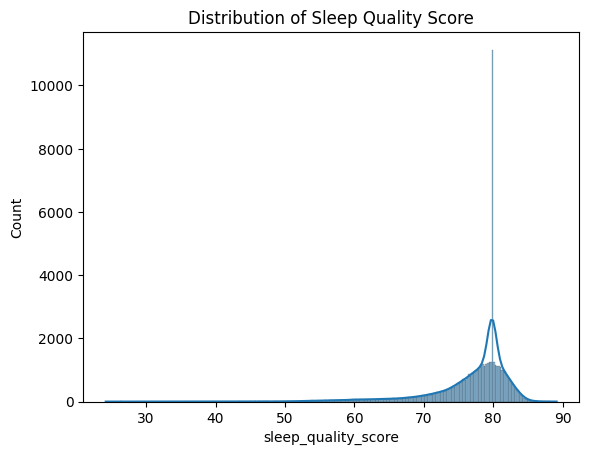

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램으로 분포 보기
sns.histplot(data['sleep_quality_score'], kde=True)
plt.title('Distribution of Sleep Quality Score')
plt.show()


In [3]:
data = data.drop([
    'sleep_length_ndays_mean',
    'sleep_efficiency_ndays_mean',
    'sleep_onset_dev_ndays_mean',
    'sleep_counts_ndays_mean',
    'sleep_length',
    'sleep_efficiency',
    'sleep_onset_dev',
    'sleep_counts'
], axis=1)





In [4]:
# 예: 상위 20%, 하위 20% 그룹 만들어서 비교
threshold_high = data['sleep_quality_score'].quantile(0.67)
threshold_low = data['sleep_quality_score'].quantile(0.33)
print(threshold_high,threshold_low)

79.84 76.94


In [5]:

data['score_level'] = 'mid'
data.loc[data['sleep_quality_score'] >= threshold_high, 'score_level'] = 'good'
data.loc[data['sleep_quality_score'] <= threshold_low, 'score_level'] = 'bad'


In [5]:
# timestamp를 datetime 타입으로 변환 (안 돼 있다면)
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 정렬
data = data.sort_values(by=['patient_id', 'timestamp']).reset_index(drop=True)
print(data)

0       2015-04-23
1       2015-04-24
2       2015-04-25
3       2015-04-26
4       2015-04-30
           ...    
58831   2019-05-08
58832   2019-05-09
58833   2019-05-10
58834   2019-05-14
58835   2019-05-17
Name: timestamp, Length: 58836, dtype: datetime64[ns]


In [8]:
print(data['patient_id'])

0          0
1          0
2          0
3          0
4          0
        ... 
58831    224
58832    224
58833    224
58834    224
58835    224
Name: patient_id, Length: 58836, dtype: int64


In [9]:
# 정규화된 데이터 저장
data.to_csv('processed_data.csv', index=False)


In [10]:
from sklearn.model_selection import train_test_split

# 예시: 수면의 질을 예측할 특징(features)와 목표(target)
features = data.drop(columns=['sleep_quality_score', 'score_level', 'patient_id', 'timestamp'])
target = data['sleep_quality_score']  # 또는 score_level로 분류 모델 만들 수도 있음

# 80% 훈련, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42  # 결과 재현 가능하게
)

In [11]:
# 훈련, 테스트 데이터 저장
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
